## Applying embedding layer

Let's apply embedding layer before linear layers


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils as torch_utils
import pandas as pd
from torch.utils.data import DataLoader,Dataset,WeightedRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="0"
# !nvidia-smi

## Construct custom dataloader

In [3]:
class Customdataset(Dataset):
    def __init__(self,x_data,y_data,transform=None):
        '''
        Call stored dataset
        
        Params
        second: Ellapsed second from the beginning of events 
        encoding_type: Encoding method for outcomeprediction ex) Static, last_state, aggregation, etc.
        '''
        
            
        # Transforms
        self.y_data=np.array(y_data)
        self.x_data=x_data
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self,idx):
        
        # Convert x and y data to torch flaot tensor
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x,y

To equalize size of each input data, delete columns that doesn't exist across all cases

In [4]:
encoding_type = 'indexbase'
prefix = 5
input_data = pd.read_csv('../data/bpic2011/'+encoding_type+'_prefix'+str(prefix)+'.csv')
input_data =input_data.drop(['Case ID'],axis=1)

y_data = [int(y) for y in list(input_data['Label'])]
input_data = input_data.drop(['Label'],axis=1)

x_data = input_data


So,  
Event log: BPIC 2011  
prefix length: 5  
Number of event categorical attributes: 8  
Number of event categorical attributes columns in pre-preprocessed: 839
Number of event continuous attributes: 2  
Number of items in single event (including embedding_dim_size,5): 10 (42,∵ 8\*5+2)  

In [5]:
event_cat =['Activity','Section','Specialism code','Producer code','org:group','Timemonth','Timeweekday','Timehour']
event_con =['Duration','Cumduration']
event_cat_col=[]
event_con_col=[]

for col in x_data.columns.values:
    for e_col in event_cat:
        if e_col in col:
            event_cat_col.append(col)
    for e_col in event_con:
        if e_col in col:
            event_con_col.append(col)
        
only_event_cat = x_data.loc[:,event_cat_col]
vocab = {word: i+2 for i, word in enumerate(event_cat_col)}
vocab['<boc>'] =0
vocab['<eoc>'] =1

embedding_dim = 84
event_cat_col = sorted(event_cat_col,key=lambda x:x.split('_')[1])
event_con_col = sorted(event_con_col,key=lambda x:x.split('_')[1])

nx_data = []
for row in range(len(x_data)):
    row_train=[]
    count=1
    pre_prefix=0
    for pos,col in enumerate(event_cat_col):
        if x_data.loc[row,col] ==1:
            row_train.append(vocab[col])
            if pre_prefix != col.split('_')[1]:
                pre_prefix=col.split('_')[1]
                count =1
            else:
                count +=1
    for pos,col in enumerate(event_con_col):
        row_train.append(x_data.loc[row,col])
    row_train = torch.tensor(row_train, dtype=torch.float)
    nx_data.append(row_train)
    
x_train, x_test, y_train, y_test = train_test_split(nx_data, y_data, test_size=0.33, random_state=6)

In [6]:
trainset = Customdataset(x_train,y_train)
testset = Customdataset(x_test,y_test)

In [7]:
batch_size =10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset,batch_size=1)

In [8]:
class MLP_prediction(nn.Module):
    def __init__(self,vocab_size, embedding_dim):
        super(MLP_prediction,self).__init__()
        
        self.embeddings = nn.Embedding(len(vocab), embedding_dim)
        self.linear2 = nn.Linear(5*(8*embedding_dim+2), 1)
        
        # MLP part
        
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.LeakyReLU()
        self.sig = nn.Sigmoid()
        
    
    def forward(self, inputs):
        """
        implement code here
        """
        l3 =[]
        for case in inputs:
            con = case[-10:]
            cat = case[:-10].long()
            l1 = self.embeddings(cat).view(-1,8*embedding_dim)
            rearrange=[]
            for pos,k in enumerate(l1):  
                t = torch.cat((k,con[pos*2:pos*2+2]))
                rearrange.append(t)
            l2 = torch.cat(rearrange).view(1,-1)
            l3.append(l2)
        hidden = torch.cat(l3)
#         hidden = self.linear1(hidden)
#         hidden = self.relu(hidden)
#         hidden = self.dropout(hidden)
        hidden = self.linear2(hidden)
        outputs = hidden.squeeze(1)
        return outputs


embedding_dim=400
model = MLP_prediction(len(vocab),embedding_dim = embedding_dim).cuda()

# Loss function & Optimizers
"""
you can change the loss and optimizer
"""
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.001)



# Hyperparameters
"""
you can change the value
"""
num_epochs = 150
batch_size = 10

In [9]:
b = torch.FloatTensor([0.23,0.1])
print(torch.argmax(b))

tensor(0)


In [10]:
def binary_acc(train_predict, train_y):
    train_predict_tag = torch.round(torch.sigmoid(train_predict))
    correct_results_sum = (train_predict_tag == train_y).sum().float()
    acc = correct_results_sum/train_y.shape[0]
    acc = torch.round(acc *100)
    
    return acc    

In [11]:
# Train FC_prediction first

accuracy_graph = {'train':[], 'test':[], 'epoch': []}
loss_graph = {'train':[], 'test':[], 'epoch': []}
# model = MLP_prediction().cuda()
best_loss=10
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0
    # Training
    for train_x, train_y in train_loader: 
        train_x,train_y = train_x.cuda(), train_y.cuda()
        train_predict = model(train_x)
        train_predict = train_predict.float()
        train_y = train_y.float()
        loss = criterion(train_predict, train_y)
        
        acc = binary_acc(train_predict, train_y)

        # Backpropagation        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # Evaluation
    if epoch % 1 ==0:
        
        test_acc = 0
        test_loss =0
        
        for test_x, test_y in test_loader:

            with torch.autograd.no_grad():
                test_x, test_y = test_x.cuda(), test_y.cuda()
                test_predict = model(test_x)
            test_predict = test_predict.float()
            test_y = test_y.float()

            loss = criterion(test_predict, test_y)
            acc = binary_acc(test_predict, test_y)
            
            test_loss += loss.item()
            test_acc += acc.item()
                               
        accuracy_graph['epoch'].append(epoch+1)
        accuracy_graph['train'].append(epoch_acc/len(train_loader))
        accuracy_graph['test'].append(test_acc/len(test_loader))
        loss_graph['epoch'].append(epoch+1)
        loss_graph['train'].append(epoch_loss/len(train_loader))
        loss_graph['test'].append(test_loss/len(test_loader))

        if epoch % 50 ==0:
            print("\ntrain accuracy: {:.2f} %, test accuracy: {:.2f} %".format(epoch_acc/len(train_loader), test_acc/len(test_loader)))
            print("epoch:{}, train_loss: {:.4f}, test_loss: {:.4f}".format(epoch+1, epoch_loss/len(train_loader), test_loss/len(test_loader))) 

        if test_loss/len(test_loader) < best_loss:
            best_loss = test_loss/len(test_loader)
            print('Saving model')
            torch.save(model.state_dict(), "./embed_predic.pt")


train accuracy: 61.25 %, test accuracy: 66.88 %
epoch:1, train_loss: 2.8733, test_loss: 2.0787
Saving model
Saving model
Saving model
Saving model
Saving model
Saving model
Saving model
Saving model
Saving model
Saving model
Saving model
Saving model
Saving model
Saving model
Saving model

train accuracy: 89.38 %, test accuracy: 68.17 %
epoch:51, train_loss: 0.2625, test_loss: 0.7842

train accuracy: 92.66 %, test accuracy: 67.20 %
epoch:101, train_loss: 0.2113, test_loss: 0.9623


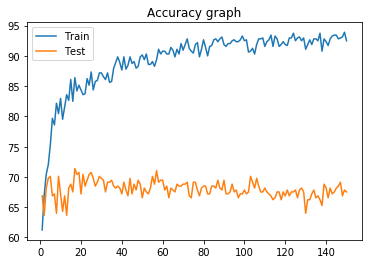

In [12]:
plt.plot(accuracy_graph['epoch'],accuracy_graph['train'],label='Train')
plt.plot(accuracy_graph['epoch'],accuracy_graph['test'], label = 'Test')
plt.title('Accuracy graph')
plt.legend()

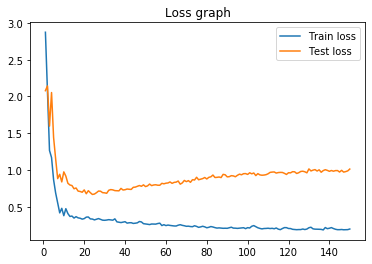

In [13]:

plt.plot(loss_graph['epoch'],loss_graph['train'],label='Train loss')
plt.plot(loss_graph['epoch'],loss_graph['test'], label = 'Test loss')
plt.title('Loss graph')
plt.legend()

In [14]:
test_acc = 0
test_loss =0
y_predict_list=[]
device = torch.device("cuda")
model = MLP_prediction(len(vocab),embedding_dim = embedding_dim).cuda()
model.load_state_dict(torch.load("./embed_predic.pt", map_location="cuda:0"))
model.to(device)
model.eval()

testset = Customdataset(x_test,y_test)
test_loader = DataLoader(testset,batch_size=1)

with torch.autograd.no_grad():
    for test_x, test_y in test_loader:
        
        test_x, test_y = test_x.cuda(), test_y.cuda()
        test_predict = model(test_x)
        test_predict = test_predict.float()
        test_y = test_y.float()
        
        test_predict_tag = torch.round(torch.sigmoid(test_predict))
        y_predict_list.append(test_predict_tag.cpu().numpy())
print(test_predict)
print(classification_report(y_test,y_predict_list))

tensor([0.6891], device='cuda:0')
              precision    recall  f1-score   support

           0       0.74      0.64      0.69       157
           1       0.68      0.77      0.72       154

    accuracy                           0.70       311
   macro avg       0.71      0.70      0.70       311
weighted avg       0.71      0.70      0.70       311

